In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Show All Datasets Available in Seaborn

In [3]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

## Load the "Flight" Dataset

In [4]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


### Concatenate the Year, Month, Day

In [5]:
df['date'] = pd.to_datetime("01-" + df['month'].astype(str) + "-" + df['year'].astype(str))

In [6]:
df.head()

,year,month,passengers,date
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


## Make "Date" column as the Index

In [7]:
df.set_index('date',inplace=True)
df.head()

,year,month,passengers
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


## Plotting the dataset - Line plot

<Axes: xlabel='date', ylabel='passengers'>

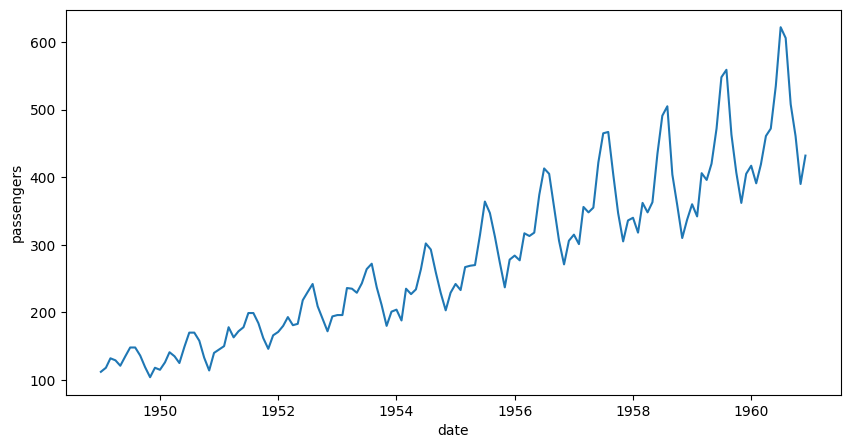

In [8]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.passengers)

In [9]:
## This Graph shows the "Sesonality" and "Trends" patterns

## If we build model on this data, model can be biased. Because time passes, the number of passengers are increased.

## Before start to build the time series model, we should check the stationarity of the data

## Check the Stationarity

#### Rolling Statistics Test

In [10]:
## Rolling Mean
df['rollMean'] = df.passengers.rolling(window=12).mean()

## Rolling Standard Deviation
df['rollStd'] = df.passengers.rolling(window=12).std()

##### Plotting the values

<Axes: xlabel='date', ylabel='passengers'>

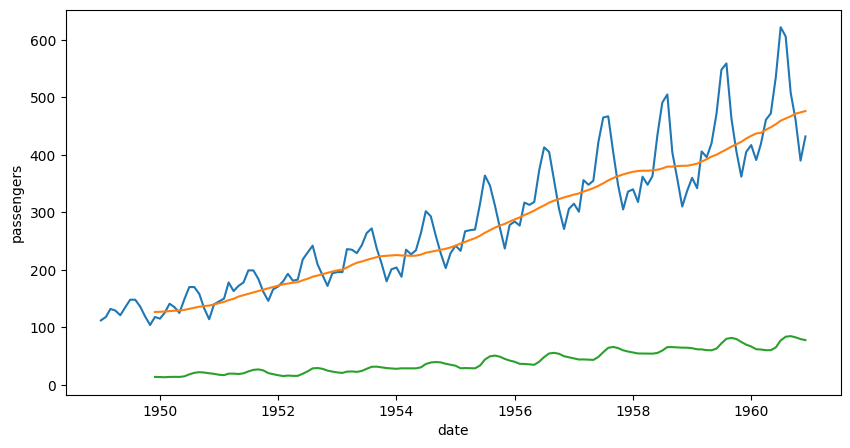

In [11]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x=df.index, y=df.passengers)
sns.lineplot(data=df, x=df.index, y=df.rollMean)
sns.lineplot(data=df, x=df.index, y=df.rollStd)

In [12]:
## Orange line = Rolling Mean
## Green line = Rolling Standard Deviation

## Rolling mean is not constant over time. That means dataset is not stationary.

### Augmented Dickey Fuller Test (ADF Test)

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
adfTest = adfuller(df['passengers'],autolag='AIC')

adfTest

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [15]:
print(f'Test Statistic: {adfTest[0]}\n')
print(f'p-value: {adfTest[1]}\n')
print(f'Number of Lags used: {adfTest[2]}\n')
print(f'Number of Observations used: {adfTest[2]}\n')
for key, value in adfTest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Test Statistic: 0.8153688792060498

p-value: 0.991880243437641

Number of Lags used: 13

Number of Observations used: 13

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


In [16]:
## Note:-
    ## Test Statistic < Critacl value  -> Reject the Null Hypothesis
    ## That means, Dataset is  Stationary

In [17]:
## Let assume that significance level = 0.05
## The result shows that Test Statistic > Critical Values. (0.815 > -2.88)
## There for we should not reject the Null Hypothesis and we can conclude that Dataset is not Stationary.

## Making Data Stationary

#### Utility Function

In [18]:
def check_stationary(dataFrame, variable):

  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()

  adfTest = adfuller(dataFrame[variable],autolag='AIC')

  print(f'Test Statistic: {adfTest[0]}\n')
  print(f'p-value: {adfTest[1]}\n')
  print(f'Number of Lags used: {adfTest[2]}\n')
  print(f'Number of Observations used: {adfTest[2]}\n')
  for key, value in adfTest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

  plt.figure(figsize=(10,5))
  sns.lineplot(data=dataFrame, x=dataFrame.index, y=variable)
  sns.lineplot(data=dataFrame, x=dataFrame.index, y='rollMean')
  sns.lineplot(data=dataFrame, x=dataFrame.index, y='rollStd')


### (1) Shift Transformation

In [19]:
shift_df = df[['passengers']]
shift_df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
# shifting
shift_df['shift'] = shift_df.passengers.shift()  ## shift by 1 month
shift_df.head()

<ipython-input-20-5c28564d15c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df['shift'] = shift_df.passengers.shift()  ## shift by 1 month


,passengers,shift
date,,
1949-01-01,112,NaN
1949-02-01,118,112.0
1949-03-01,132,118.0
1949-04-01,129,132.0
1949-05-01,121,129.0


In [21]:
# find shift difference
shift_df['shiftDiff'] = shift_df.passengers - shift_df['shift']
shift_df.head()

<ipython-input-21-f5898eb9111e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df['shiftDiff'] = shift_df.passengers - shift_df['shift']


,passengers,shift,shiftDiff
date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0


<ipython-input-18-ef25bf5507fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
<ipython-input-18-ef25bf5507fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()


Test Statistic: -2.8292668241700047

p-value: 0.05421329028382478

Number of Lags used: 12

Number of Observations used: 12

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


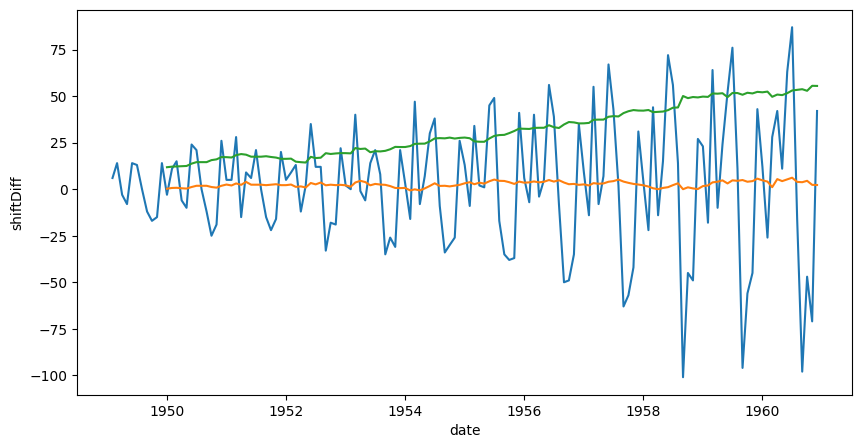

In [22]:
## Test stationarity
check_stationary(shift_df.dropna(), 'shiftDiff')

### (2) Log Transformation

In [23]:
log_df = df[['passengers']]
log_df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [24]:
# logging
log_df['log'] = np.log(log_df['passengers'])
log_df.head()

<ipython-input-24-6a029cfb601a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['log'] = np.log(log_df['passengers'])


,passengers,log
date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


<ipython-input-18-ef25bf5507fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
<ipython-input-18-ef25bf5507fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()


Test Statistic: -1.7170170891069683

p-value: 0.4223667747703874

Number of Lags used: 13

Number of Observations used: 13

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


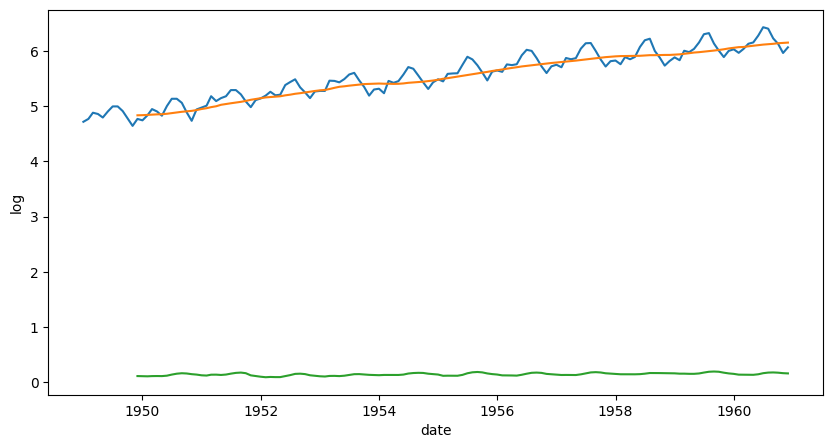

In [25]:
## Test stationarity
check_stationary(log_df, 'log')

### (3) Square Root Transformation

In [26]:
sqrt_df = df[['passengers']]
sqrt_df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [27]:
sqrt_df['sqrt'] = np.sqrt(df['passengers'])
sqrt_df.head()

<ipython-input-27-4b5e362e3861>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqrt_df['sqrt'] = np.sqrt(df['passengers'])


,passengers,sqrt
date,,
1949-01-01,112,10.583005
1949-02-01,118,10.862780
1949-03-01,132,11.489125
1949-04-01,129,11.357817
1949-05-01,121,11.000000


<ipython-input-18-ef25bf5507fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
<ipython-input-18-ef25bf5507fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()


Test Statistic: -0.3458537677156893

p-value: 0.9187543217618346

Number of Lags used: 13

Number of Observations used: 13

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


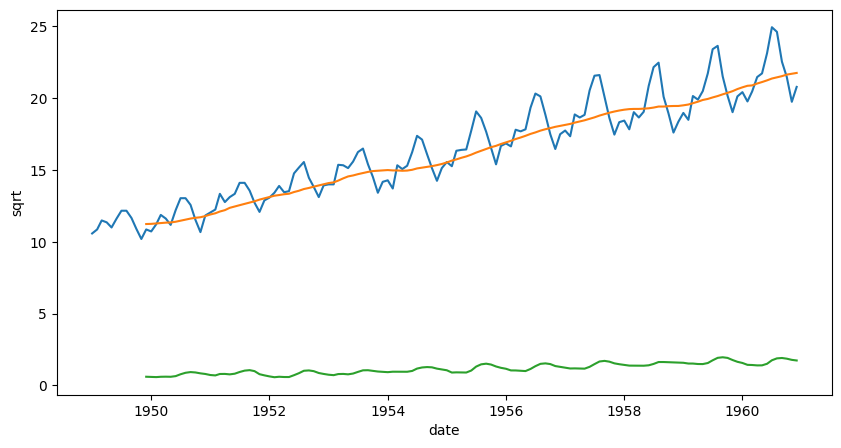

In [28]:
## Test stationarity
check_stationary(sqrt_df,'sqrt')

### (4) Cube Root Transformation

In [29]:
cbrt_df = df[['passengers']]
cbrt_df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [30]:
cbrt_df['cbrt'] = np.cbrt(df['passengers'])
cbrt_df.head()

<ipython-input-30-ae392f99a009>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbrt_df['cbrt'] = np.cbrt(df['passengers'])


,passengers,cbrt
date,,
1949-01-01,112,4.820285
1949-02-01,118,4.904868
1949-03-01,132,5.091643
1949-04-01,129,5.052774
1949-05-01,121,4.946087


<ipython-input-18-ef25bf5507fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
<ipython-input-18-ef25bf5507fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()


Test Statistic: -0.8100350722186402

p-value: 0.8161565539700493

Number of Lags used: 13

Number of Observations used: 13

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


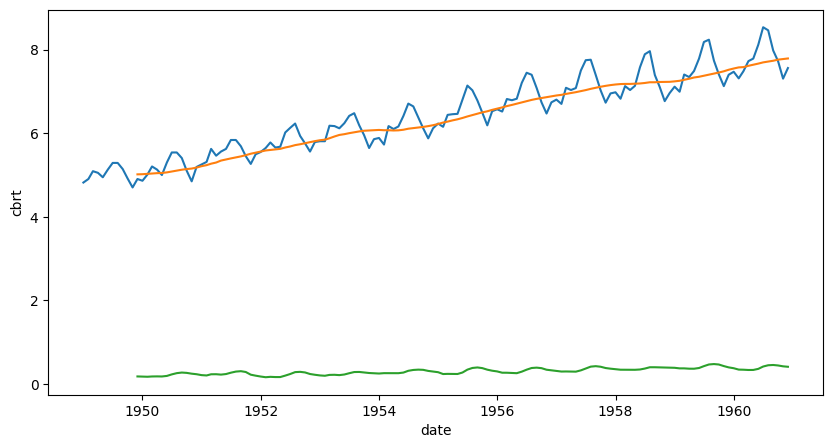

In [31]:
## Test stationarity
check_stationary(cbrt_df,'cbrt')

### (5) Log & Square Root Transformation

In [32]:
log_df2 = log_df[['passengers','log']]
log_df2['log_sqrt'] = np.sqrt(log_df['log'])
log_df2.head()

<ipython-input-32-1a997c4bc65e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['log_sqrt'] = np.sqrt(log_df['log'])


,passengers,log,log_sqrt
date,,,
1949-01-01,112,4.718499,2.172211
1949-02-01,118,4.770685,2.184190
1949-03-01,132,4.882802,2.209706
1949-04-01,129,4.859812,2.204498
1949-05-01,121,4.795791,2.189929


Test Statistic: -1.9425283300799183

p-value: 0.31232635444963885

Number of Lags used: 13

Number of Observations used: 13

Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


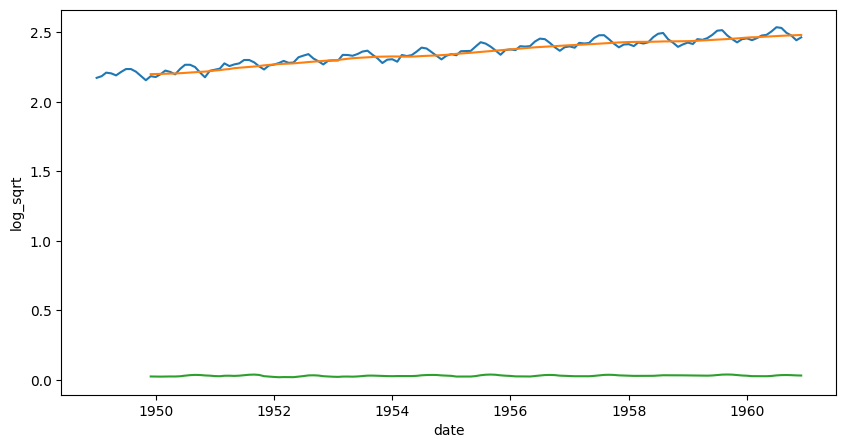

In [33]:
## Test stationarity
check_stationary(log_df2,'log_sqrt')

### (6) Log, Square Root & Shift Transformation

In [34]:
log_df3 = log_df2[['passengers','log']]
log_df3['log_sqrt'] = np.sqrt(log_df['log'])
log_df3['logSqrtShiftDiff'] = log_df3['log_sqrt'] - log_df3['log_sqrt'].shift()  # shift by 1
log_df3.head()

<ipython-input-34-3e4e18669e46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df3['log_sqrt'] = np.sqrt(log_df['log'])
<ipython-input-34-3e4e18669e46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df3['logSqrtShiftDiff'] = log_df3['log_sqrt'] - log_df3['log_sqrt'].shift()  # shift by 1


,passengers,log,log_sqrt,logSqrtShiftDiff
date,,,,
1949-01-01,112,4.718499,2.172211,NaN
1949-02-01,118,4.770685,2.184190,0.011979
1949-03-01,132,4.882802,2.209706,0.025517
1949-04-01,129,4.859812,2.204498,-0.005208
1949-05-01,121,4.795791,2.189929,-0.014569


<ipython-input-18-ef25bf5507fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[variable].rolling(window=12).mean()
<ipython-input-18-ef25bf5507fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[variable].rolling(window=12).std()


Test Statistic: -2.6110192865837893

p-value: 0.0907411248670495

Number of Lags used: 14

Number of Observations used: 14

Critial Values:
   1%, -3.4825006939887997
Critial Values:
   5%, -2.884397984161377
Critial Values:
   10%, -2.578960197753906


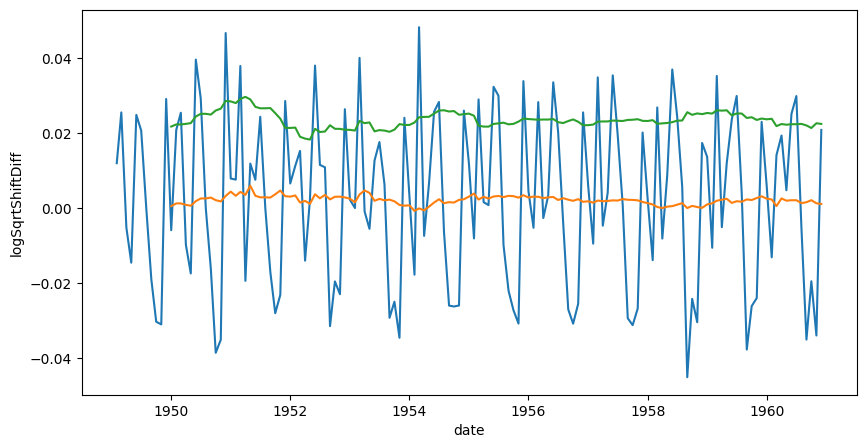

In [35]:
## Test stationarity
check_stationary(log_df3.dropna(),'logSqrtShiftDiff')

## Model Building

In [36]:
data = df[['passengers']].copy(deep=True)

In [37]:
data.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [38]:
data['firstDiff'] = data['passengers'].diff()
data.head()

,passengers,firstDiff
date,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [39]:
data['twelveDiff'] = data['passengers'].diff(12)
data.head()

,passengers,firstDiff,twelveDiff
date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN


### ARIMA Model

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##### First Difference

In [41]:
# d = 1

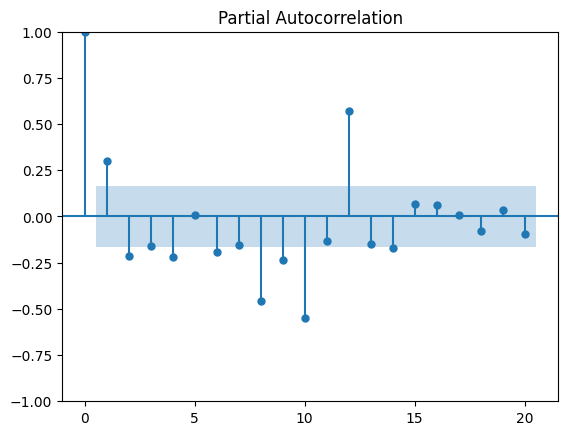

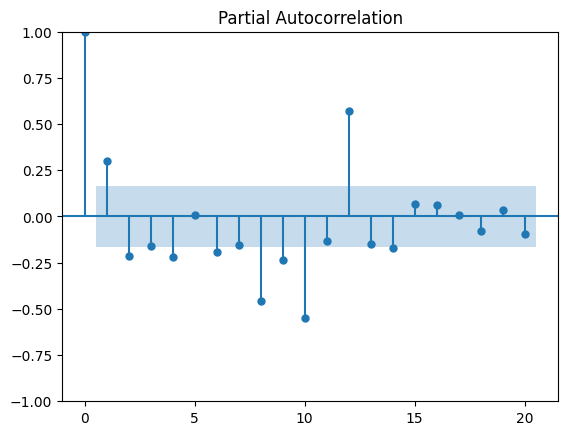

In [42]:
plot_pacf(data['firstDiff'].dropna(), lags=20)

In [43]:
## p = 1
# Lag 1 shows a strong spike, which is significant.
# From Lag 3 onwards, the spikes fall within the confidence interval, making them insignificant.

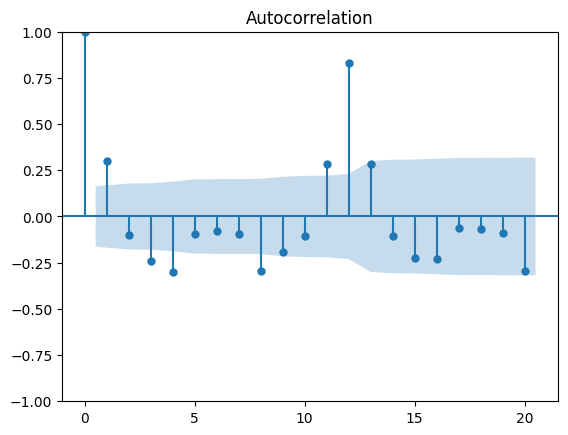

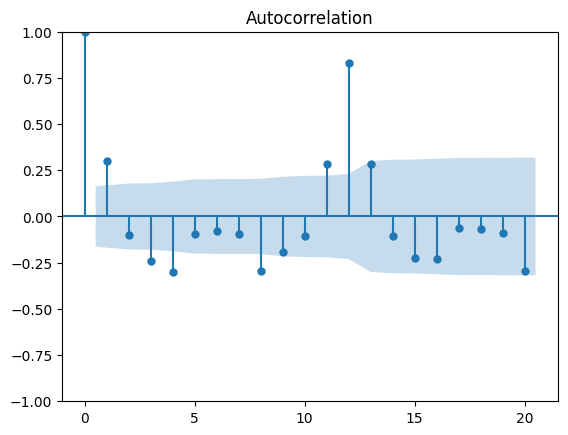

In [44]:
plot_acf(data['firstDiff'].dropna(), lags=20)

In [45]:
## q = 3

# There is a strong spike at Lag 1.
# At Lag 2, the spike is smaller but still significant.

##### Train - Test Split

In [46]:
train_data = data[:round(len(data)*0.70)]
train_data.tail()

,passengers,firstDiff,twelveDiff
date,,,
1957-01-01,315,9.0,31.0
1957-02-01,301,-14.0,24.0
1957-03-01,356,55.0,39.0
1957-04-01,348,-8.0,35.0
1957-05-01,355,7.0,37.0


In [47]:
test_data = data[round(len(data)*0.70):]
test_data.head()

,passengers,firstDiff,twelveDiff
date,,,
1957-06-01,422,67.0,48.0
1957-07-01,465,43.0,52.0
1957-08-01,467,2.0,62.0
1957-09-01,404,-63.0,49.0
1957-10-01,347,-57.0,41.0


##### Model Building

In [48]:
model = ARIMA(train_data['passengers'],order=(1,1,3))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


##### predict

In [49]:
prediction = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
data['arimaPredict'] = prediction
data.tail()

,passengers,firstDiff,twelveDiff,arimaPredict
date,,,,
1960-08-01,606,-16.0,47.0,341.111333
1960-09-01,508,-98.0,45.0,341.111333
1960-10-01,461,-47.0,54.0,341.111333
1960-11-01,390,-71.0,28.0,341.111333
1960-12-01,432,42.0,27.0,341.111333


##### plotting

In [50]:
data.dropna()

,passengers,firstDiff,twelveDiff,arimaPredict
date,,,,
1957-06-01,422,67.0,48.0,363.295709
1957-07-01,465,43.0,52.0,351.699792
1957-08-01,467,2.0,62.0,346.961970
1957-09-01,404,-63.0,49.0,344.344094
1957-10-01,347,-57.0,41.0,342.897590
1957-11-01,305,-42.0,34.0,342.098327
1957-12-01,336,31.0,30.0,341.656695
1958-01-01,340,4.0,25.0,341.412672
1958-02-01,318,-22.0,17.0,341.277838


<Axes: xlabel='date', ylabel='passengers'>

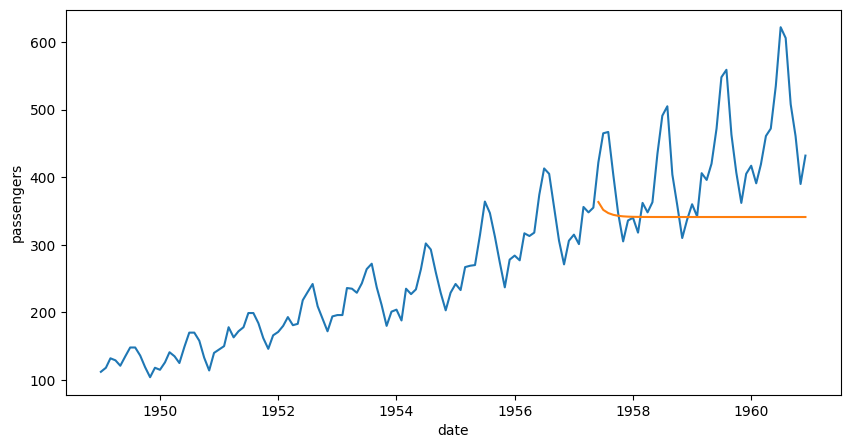

In [51]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x=data.index, y='passengers')
sns.lineplot(data=data, x=data.index, y='arimaPredict')

##### Mean Square Error

In [52]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test_data['passengers'],prediction))

111.1101033142743

### SARIMAX Model

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
# d=1

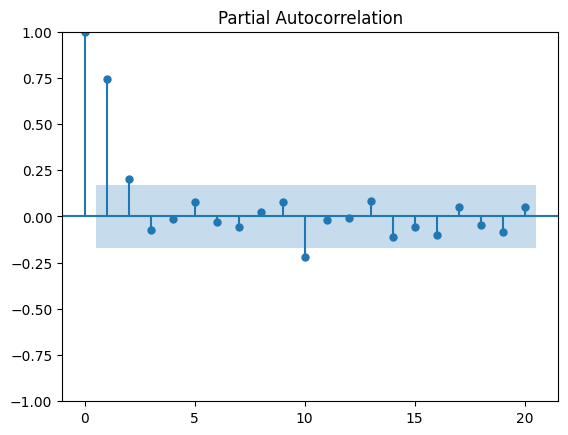

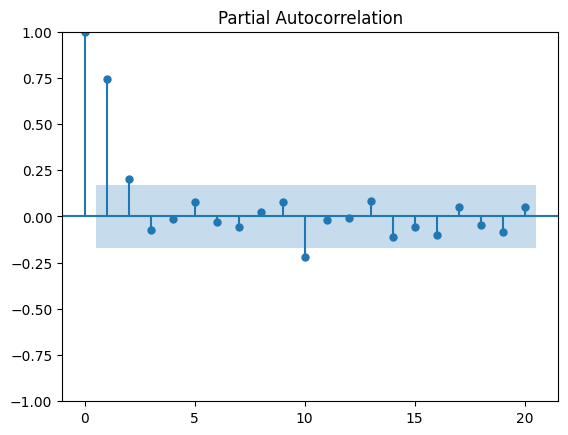

In [55]:
plot_pacf(data['twelveDiff'].dropna(),lags=20)

In [56]:
## p =1,2

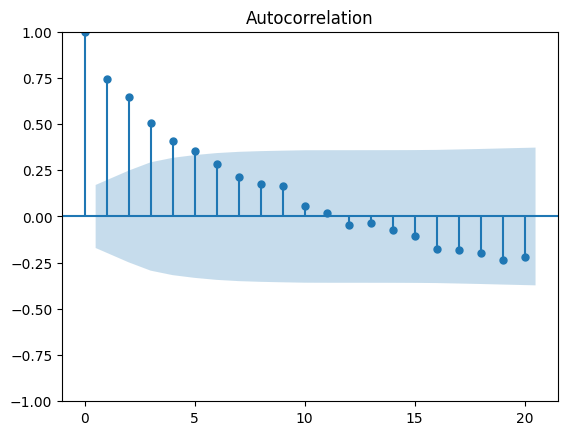

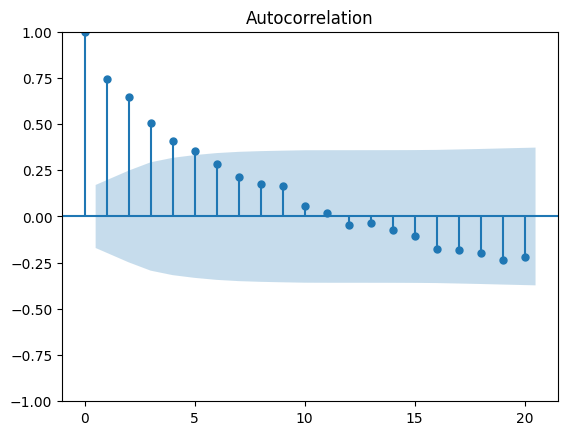

In [57]:
plot_acf(data['twelveDiff'].dropna(), lags=20)

In [58]:
## q= 1,2,3,4

In [59]:
## We can use combination of p,d,q values to plot

In [60]:
model = SARIMAX(train_data['passengers'],order=(1,1,1),seasonal_order=(1,1,1,12))
model_fit = model.fit()
prediction = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
data['sarimaxPredict'] = prediction
data.tail()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,passengers,firstDiff,twelveDiff,arimaPredict,sarimaxPredict
date,,,,,
1960-08-01,606,-16.0,47.0,341.111333,553.752666
1960-09-01,508,-98.0,45.0,341.111333,506.446839
1960-10-01,461,-47.0,54.0,341.111333,458.917186
1960-11-01,390,-71.0,28.0,341.111333,423.571506
1960-12-01,432,42.0,27.0,341.111333,459.639431


In [61]:
data.dropna()

,passengers,firstDiff,twelveDiff,arimaPredict,sarimaxPredict
date,,,,,
1957-06-01,422,67.0,48.0,363.295709,407.233413
1957-07-01,465,43.0,52.0,351.699792,449.482340
1957-08-01,467,2.0,62.0,346.961970,438.898634
1957-09-01,404,-63.0,49.0,344.344094,392.346923
1957-10-01,347,-57.0,41.0,342.897590,345.264075
1957-11-01,305,-42.0,34.0,342.098327,309.806557
1957-12-01,336,31.0,30.0,341.656695,346.192279
1958-01-01,340,4.0,25.0,341.412672,354.500544
1958-02-01,318,-22.0,17.0,341.277838,341.934548


<Axes: xlabel='date', ylabel='passengers'>

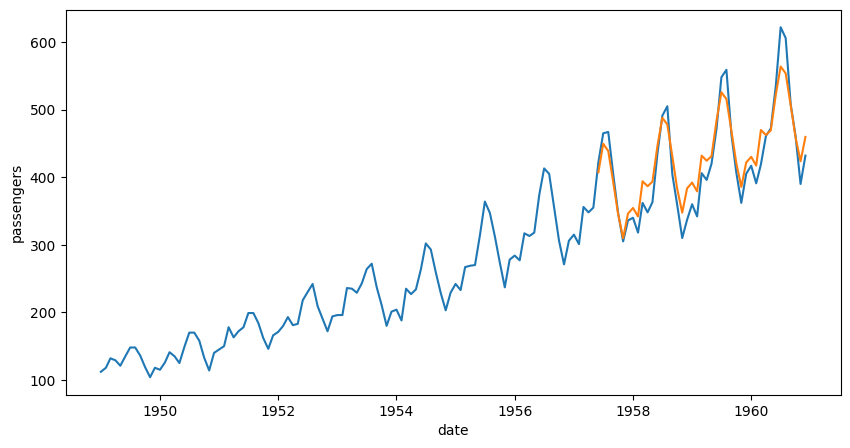

In [62]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x=data.index, y='passengers')
sns.lineplot(data=data, x=data.index, y='sarimaxPredict')


In [63]:
np.sqrt(mean_squared_error(test_data['passengers'],prediction))

26.718944646411465

In [64]:
## SARIMAX Models' prediction is better than ARIMAX Models' prediction

## Predict Future Dates

In [65]:
data.tail()

,passengers,firstDiff,twelveDiff,arimaPredict,sarimaxPredict
date,,,,,
1960-08-01,606,-16.0,47.0,341.111333,553.752666
1960-09-01,508,-98.0,45.0,341.111333,506.446839
1960-10-01,461,-47.0,54.0,341.111333,458.917186
1960-11-01,390,-71.0,28.0,341.111333,423.571506
1960-12-01,432,42.0,27.0,341.111333,459.639431


In [69]:
futureDates = pd.DataFrame(pd.date_range(start='1961-01-01',end='1962-12-01',freq='MS'),columns=['Dates'])
futureDates.set_index("Dates",inplace=True)
futureDates.head()

""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


#### Make Prediction

In [71]:
model_fit.predict(start=futureDates.index[0], end=futureDates.index[-1])

#### Plotting

<Axes: xlabel='date', ylabel='passengers'>

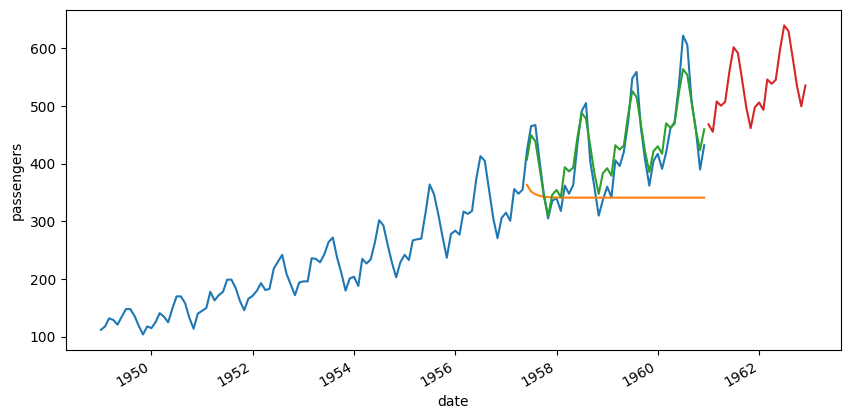

In [73]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x=data.index, y='passengers')
sns.lineplot(data=data, x=data.index, y='arimaPredict')
sns.lineplot(data=data, x=data.index, y='sarimaxPredict')
model_fit.predict(start=futureDates.index[0], end=futureDates.index[-1]).plot()



In [ ]:
# blue = Passengers
# green = SARIMAX Model
# yellow = ARIMA Model
# red = future predictions using SARIMAX model